In [56]:
pip install -r requirements.txt
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.8/31.8 MB 69.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 109.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from unidecode import unidecode
import zipfile
import random

from src.models.rnn_encoder_decoder import *
from src.features.functions_preprocessing import *

# **Kaggle dataset**

In [2]:
!kaggle datasets download -d sbhatti/news-summarization

Dataset URL: https://www.kaggle.com/datasets/sbhatti/news-summarization
License(s): CC0-1.0
news-summarization.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
with zipfile.ZipFile('news-summarization.zip', 'r') as zip_ref:
    zip_ref.extractall('news-summarization')

In [4]:
news_data = pd.read_csv("news-summarization/data.csv")

In [5]:
news_data.head()

,Unnamed: 0,ID,Content,Summary,Dataset
0,0,f49ee725a0360aa6881ed1f7999cc531885dd06a,New York police are concerned drones could bec...,Police have investigated criminals who have ri...,CNN/Daily Mail
1,1,808fe317a53fbd3130c9b7563341a7eea6d15e94,By . Ryan Lipman . Perhaps Australian porn sta...,Porn star Angela White secretly filmed sex act...,CNN/Daily Mail
2,2,98fd67bd343e58bc4e275bbb5a4ea454ec827c0d,"This was, Sergio Garcia conceded, much like be...",American draws inspiration from fellow country...,CNN/Daily Mail
3,3,e12b5bd7056287049d9ec98e41dbb287bd19a981,An Ebola outbreak that began in Guinea four mo...,World Health Organisation: 635 infections and ...,CNN/Daily Mail
4,4,b83e8bcfcd51419849160e789b6658b21a9aedcd,By . Associated Press and Daily Mail Reporter ...,A sinkhole opened up at 5:15am this morning in...,CNN/Daily Mail


In [6]:
N = random.randint(1, len(news_data))

print(news_data["Content"][N])
print()
print(news_data["Summary"][N])

By . Hugo Gye . PUBLISHED: . 13:41 EST, 29 October 2012 . | . UPDATED: . 13:43 EST, 29 October 2012 . The father of one of the Navy SEALs who was killed in the Libya consulate raid has launched another attack on President Obama's handling of the crisis, saying: 'It's better to die the death of a hero than it is to live the life of a coward.' Charles Woods, father of Tyrone Woods, revealed his suspicion that Obama was 'responsible for the death of my son' - but he insisted he was not angry at the President. He previously made headlines when he slammed Joe Biden for acting inappropriately during the repatriation ceremony for his son's body. Grief: Charles Woods, left, is the father of Tyrone Woods, right, who died in the Benghazi raid on September 11 . Criticism: Mr Woods had harsh words for President Obama over his response to the attack . Tyrone died on September 11 alongside . his colleague Glen Doherty while the pair were protecting a CIA . building next to the U.S. consulate in Beng

In [7]:
lengths_article = news_data["Content"].str.len()
lengths_article.describe()

count    8.704870e+05
mean     4.008553e+03
std      5.585502e+03
min      1.400000e+01
25%      2.052000e+03
50%      3.316000e+03
75%      4.958000e+03
max      2.921656e+06
Name: Content, dtype: float64

In [8]:
news_data = news_data[(lengths_article >= lengths_article.quantile(0.05)) & (lengths_article <= lengths_article.quantile(0.95))]

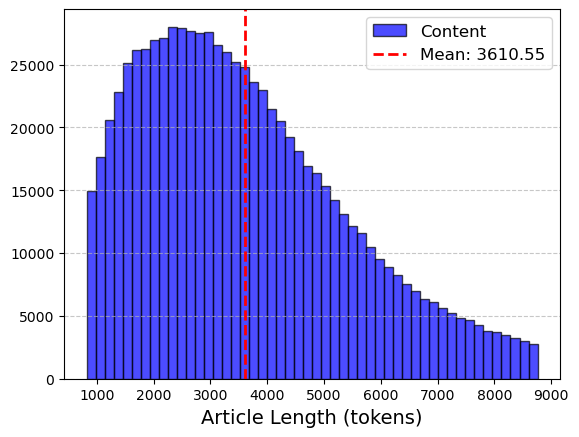

In [9]:
pd.DataFrame(news_data["Content"].str.len()).plot(kind='hist', bins=50, edgecolor='black', alpha=0.7, color='blue')
plt.axvline(news_data["Content"].str.len().mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {news_data["Content"].str.len().mean():.2f}')
plt.xlabel("Article Length (tokens)", fontsize=14)
plt.ylabel("")
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [10]:
lengths_summary = news_data["Summary"].str.len()
lengths_summary.describe()

count    783457.000000
mean        288.041624
std         226.311050
min           1.000000
25%         154.000000
50%         244.000000
75%         328.000000
max        8541.000000
Name: Summary, dtype: float64

In [11]:
news_data = news_data[(lengths_summary >= lengths_summary.quantile(0.05)) & (lengths_summary <= lengths_summary.quantile(0.95))]

In [12]:
news_data["Summary"].str.len().describe()

count    705951.000000
mean        255.337233
std         104.177187
min         103.000000
25%         168.000000
50%         244.000000
75%         317.000000
max         597.000000
Name: Summary, dtype: float64

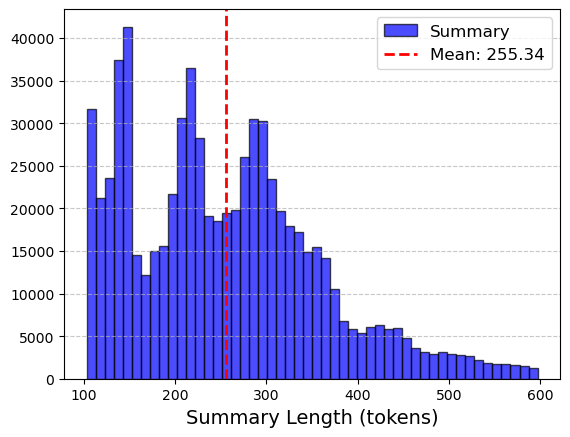

In [13]:
news_data["Summary"].str.len().plot(kind='hist', bins=50, edgecolor='black', alpha=0.7, color='blue')
plt.axvline(news_data["Summary"].str.len().mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {news_data["Summary"].str.len().mean():.2f}')
plt.xlabel("Summary Length (tokens)", fontsize=14)
plt.ylabel("")
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
news_data["Content"] = news_data["Content"].apply(preprocess_article)
news_data["Summary"] = news_data["Summary"].apply(preprocess_summary)

In [ ]:
from gensim.models import KeyedVectors

# Load pre-trained Word2Vec model
word2vec_path = "GoogleNews-vectors-negative300.bin"  # Update the path as needed
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Check embedding for a word
print(word2vec["cat"])  # Example: Get the 300-dim vector for "cat"

# **RNN**

In [1]:
_ = torch.manual_seed(42)

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# **LLM Llama 3.2**

In [ ]:
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForCausalLM
import yaml

with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

hf_token = config["huggingface"]["token"]
login("hf_token")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B")